Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

We create the data loaders of our dataset

In [2]:
def denoise_bernoulli_data(X):
    """Denoise data by converting to binary values"""
    # return X
    return (X >= 0.5).astype(float)

In [3]:
def create_dataloaders(dimensionality, batch_size=32, random_state=42):
    """
    Create PyTorch DataLoaders for training, validation, and test sets.
    
    Args:
        dimensionality (int): Dimensionality of the input features
        batch_size (int): Batch size for DataLoaders
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """

    # Load pre-defined train and test datasets
    X_train = np.load(f'Datasets_Train_Test_Split/kryptonite-{dimensionality}-X_train.npy')
    y_train = np.load(f'Datasets_Train_Test_Split/kryptonite-{dimensionality}-y_train.npy')
    X_test = np.load(f'Datasets_Train_Test_Split/kryptonite-{dimensionality}-X_test.npy')
    y_test = np.load(f'Datasets_Train_Test_Split/kryptonite-{dimensionality}-y_test.npy')
    
    # Split the training data into new training data (80%) and validation data (20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,  # 20% for validation
        random_state=random_state,
        shuffle=True
    )
    
    # Apply denoising
    X_train = denoise_bernoulli_data(X_train)
    X_val = denoise_bernoulli_data(X_val)
    X_test = denoise_bernoulli_data(X_test)

    # Convert numpy arrays to PyTorch tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Dataset splits:")
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    return train_loader, val_loader, test_loader

We now create the Neural Network model

In [4]:
"""
For Binary Classification:
1. Input layer shape has the same number of neurons as the number of features in the dataset
2. At least 1 hidden layer
3. 10 to 512 neurons per hidden layer
4. The output layer shape has 1 neuron (one class or the other)
5. Typically we use ReLU as hidden layer activation function
6. We use Sigmoid as the output layer activation function for binary classification (torch.sigmoid)
7. We use Binary Cross Entropy as the loss function (nn.BCELoss)
8. The optimizer can be SGD, Adam, etc.
"""

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_dim=45, dropout_rate=0.3):
        super(NeuralNetwork, self).__init__()
        
        # Ensure input_dim is correct
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),  # Input shape: (batch_size, input_dim)
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid(),
        )
        
        # Initialize weights, based on https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_init_weights.py
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Ensure input is in the correct shape
        # x shape should be (batch_size, input_dim)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        return self.network(x)

We now create the methods to train and evaluate the model

In [12]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=1000, early_stopping_patience=50):
    # Accuracies are computed based on https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            dim_size = inputs.size(1)

            # Ensure inputs are in the correct shape
            inputs = inputs.view(inputs.size(0), -1)  # Flatten if necessary

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            train_correct += (predicted == labels.unsqueeze(1)).sum().item()
            train_total += labels.size(0)

        train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total * 100

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Ensure inputs are in the correct shape
                inputs = inputs.view(inputs.size(0), -1)  # Flatten if necessary

                outputs = model(inputs)

                loss = loss_fn(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs >= 0.5).float()
                val_correct += (predicted == labels.unsqueeze(1)).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            save_model(model, f'best_model_{dim_size}.pth')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, dim):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Ensure inputs are in the correct shape
            inputs = inputs.view(inputs.size(0), -1)  # Flatten if necessary
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float().cpu().numpy()
            all_preds.extend(predictions)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds).squeeze()
    print(all_preds)
    all_labels = np.array(all_labels)
    np.save(f'kryptonite_{dim}_pred_nn.npy', all_preds)

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

# Save the model
def save_model(model, path='model.pth'):
    torch.save(model.state_dict(), path)

# Load the model
def load_model_weights(model, path='model.pth'):
    model.load_state_dict(torch.load(path, weights_only=True))
    
def load_model(path='model.pth'):
    return torch.load(path, weights_only=True)

Finally, the method to actually train our model and evaluate it

In [22]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot training curves
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    
    plt.show()

def run_training(train_loader, val_loader, device, input_dim=45, num_epochs=1000, early_stopping_patience=50, learning_rate=0.001, weight_decay=0.001, momentum=0.9, dropout_rate=0.3, test_loader=None):
	# Initialize model and move to device
	model = NeuralNetwork(input_dim=input_dim, dropout_rate=dropout_rate).to(device)
	# We use binary cross-entropy, for Binary classification. We apply Sigmoid in the NN
	criterion = torch.nn.BCELoss()
	# We use Stochastic Gradient Descent with L2 regularization and momentum
	# Momentum: https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
	# L2 Reg: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/ 
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
	# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
	print(f"\nTraining-------------------------------")
	# Train the model
	train_losses, val_losses, train_accuracies, val_accuracies = train_model(
	    model=model,
	    train_loader=train_loader,
	    val_loader=val_loader,
	    loss_fn=criterion,
	    optimizer=optimizer,
	    num_epochs=num_epochs,
	    early_stopping_patience=early_stopping_patience
	)
	# Load the best model for evaluation
	load_model_weights(model, f'best_model_{input_dim}.pth')
	print(f"\nEvaluating-------------------------------")
      
	test_metrics = {}
    
	plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
	return model, test_metrics, train_accuracies

We can now run the training and evaluation pipeline

We set the dimensionality of the dataset first:

In [7]:
momentum = 0.9
weight_decay = 0.0001
learning_rate = 0.001
num_epochs = 1000
early_stopping_patience = 50
dropout_rate = 0.15
batch_size=16

And we get the device:

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Finally:

In [ ]:
def run_one_dim(dimension: int, save: bool):
	print(f"Running code for dim {dimension}")

	train_loader, val_loader, test_loader = create_dataloaders(dimensionality=dimension, batch_size=batch_size)
	start_time = time.time()

	# Assuming you have already created your DataLoaders
	model, test_metrics_run, train_accuracies_run = run_training(
	    train_loader, val_loader, test_loader=test_loader, input_dim=dimension, device=device, learning_rate=learning_rate,
	    weight_decay=weight_decay, momentum=momentum, num_epochs=num_epochs, early_stopping_patience=early_stopping_patience,
	    dropout_rate=dropout_rate)	
	end_time = time.time()

	print(f"\nTraining took: {end_time - start_time:.2f} seconds")

    # Dictionary to store both metrics together
	metrics_dict = {
        'training_accuracies': train_accuracies_run,
		'test_accuracy': test_metrics_run.get('accuracy')
	}

	# Save the dictionary as an npy file
	if save:
		np.save(f'metrics_dim_{dimension}.npy', metrics_dict)

	print("\nTest Set Metrics:")
	for metric, value in test_metrics_run.items():
	    print(f"{metric.capitalize()}: {value:.4f}")

def run_all_dims(dimensions, save_files):

	for dimension in dimensions:
		run_one_dim(dimension, save_files)

Running code for dim 9
Dataset splits:
Training set size: 11520
Validation set size: 2880
Test set size: 3600

Training-------------------------------
Epoch [10/1000], Train Loss: 0.2095, Val Loss: 0.1559
Epoch [20/1000], Train Loss: 0.1930, Val Loss: 0.1551
Epoch [30/1000], Train Loss: 0.1853, Val Loss: 0.1584
Epoch [40/1000], Train Loss: 0.1839, Val Loss: 0.1575
Epoch [50/1000], Train Loss: 0.1810, Val Loss: 0.1566
Epoch [60/1000], Train Loss: 0.1792, Val Loss: 0.1550
Epoch [70/1000], Train Loss: 0.1782, Val Loss: 0.1596
Early stopping at epoch 79

Evaluating-------------------------------
[1. 1. 1. ... 0. 0. 1.]


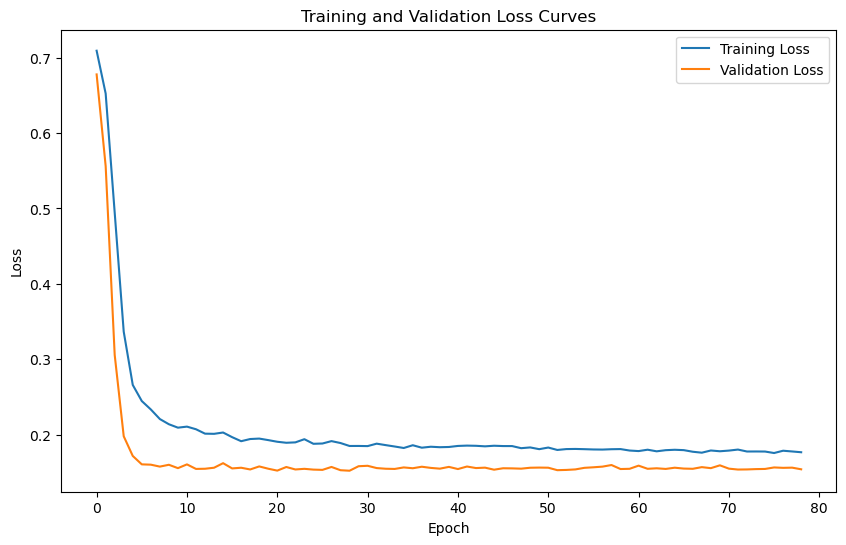

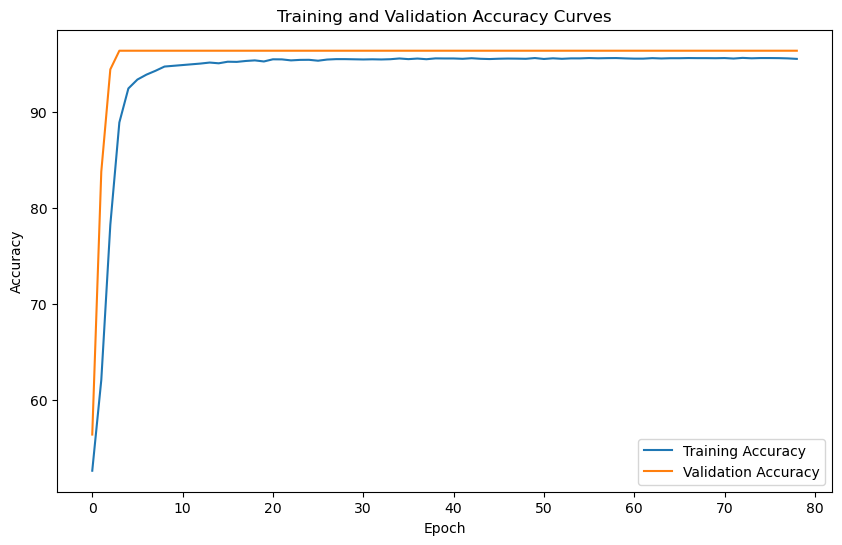


Training took: 151.90 seconds

Test Set Metrics:
Accuracy: 0.9575
Precision: 0.9586
Recall: 0.9559
F1: 0.9573
Running code for dim 12
Dataset splits:
Training set size: 15360
Validation set size: 3840
Test set size: 4800

Training-------------------------------
Epoch [10/1000], Train Loss: 0.3672, Val Loss: 0.2533
Epoch [20/1000], Train Loss: 0.2066, Val Loss: 0.1699
Epoch [30/1000], Train Loss: 0.1824, Val Loss: 0.1675
Epoch [40/1000], Train Loss: 0.1722, Val Loss: 0.1657
Epoch [50/1000], Train Loss: 0.1695, Val Loss: 0.1640
Epoch [60/1000], Train Loss: 0.1624, Val Loss: 0.1689
Epoch [70/1000], Train Loss: 0.1597, Val Loss: 0.1662
Epoch [80/1000], Train Loss: 0.1597, Val Loss: 0.1691
Early stopping at epoch 84

Evaluating-------------------------------
[0. 1. 0. ... 1. 1. 1.]


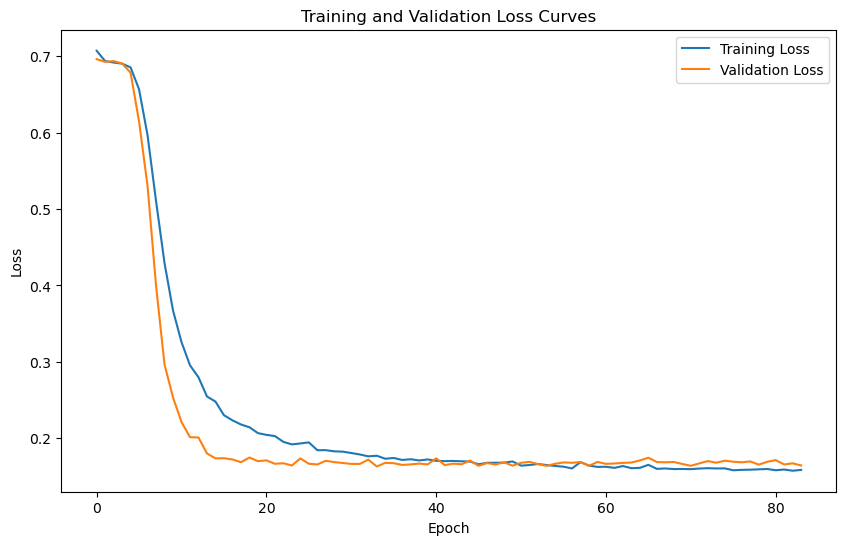

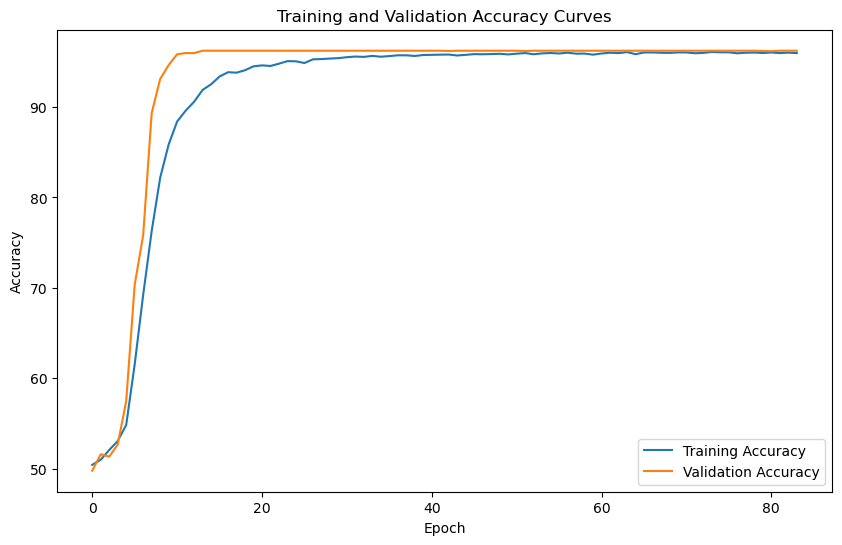


Training took: 211.19 seconds

Test Set Metrics:
Accuracy: 0.9656
Precision: 0.9659
Recall: 0.9655
F1: 0.9657
Running code for dim 15
Dataset splits:
Training set size: 19200
Validation set size: 4800
Test set size: 6000

Training-------------------------------
Epoch [10/1000], Train Loss: 0.6478, Val Loss: 0.6201
Epoch [20/1000], Train Loss: 0.2865, Val Loss: 0.2295
Epoch [30/1000], Train Loss: 0.2108, Val Loss: 0.1784
Epoch [40/1000], Train Loss: 0.1857, Val Loss: 0.1708
Epoch [50/1000], Train Loss: 0.1759, Val Loss: 0.1658
Epoch [60/1000], Train Loss: 0.1649, Val Loss: 0.1646
Epoch [70/1000], Train Loss: 0.1612, Val Loss: 0.1722
Epoch [80/1000], Train Loss: 0.1542, Val Loss: 0.1643
Epoch [90/1000], Train Loss: 0.1545, Val Loss: 0.1635
Epoch [100/1000], Train Loss: 0.1513, Val Loss: 0.1799
Epoch [110/1000], Train Loss: 0.1471, Val Loss: 0.1707
Early stopping at epoch 116

Evaluating-------------------------------
[0. 0. 1. ... 1. 1. 1.]


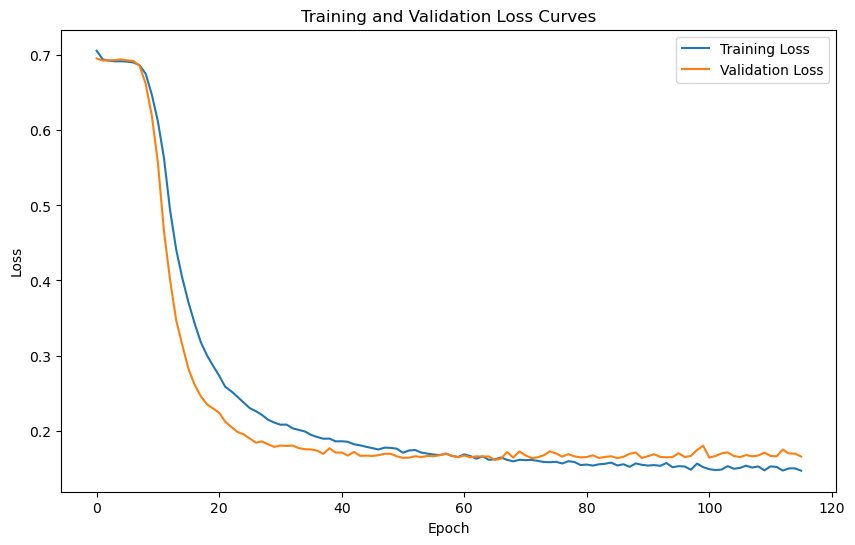

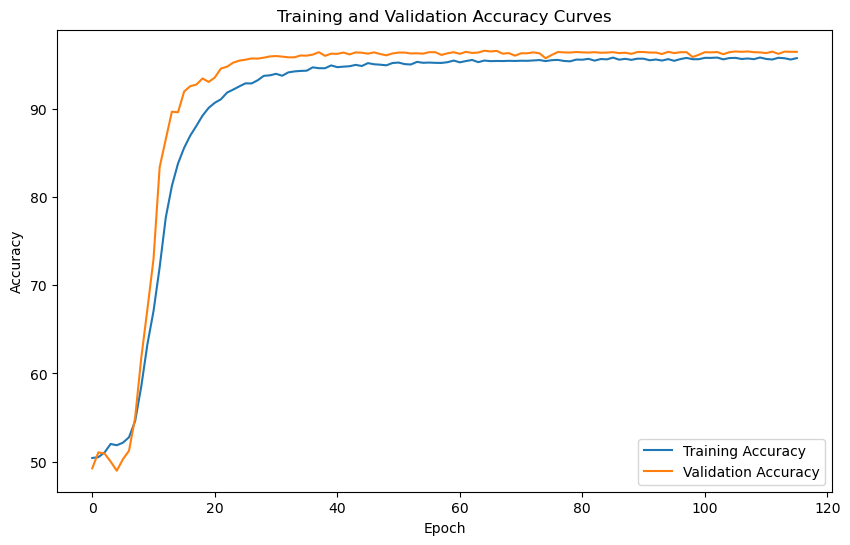


Training took: 373.10 seconds

Test Set Metrics:
Accuracy: 0.9627
Precision: 0.9601
Recall: 0.9652
F1: 0.9627
Running code for dim 18
Dataset splits:
Training set size: 23040
Validation set size: 5760
Test set size: 7200

Training-------------------------------
Epoch [10/1000], Train Loss: 0.6882, Val Loss: 0.6954
Epoch [20/1000], Train Loss: 0.6441, Val Loss: 0.6412
Epoch [30/1000], Train Loss: 0.4754, Val Loss: 0.4173
Epoch [40/1000], Train Loss: 0.3329, Val Loss: 0.2841
Epoch [50/1000], Train Loss: 0.2699, Val Loss: 0.2256
Epoch [60/1000], Train Loss: 0.2496, Val Loss: 0.2118
Epoch [70/1000], Train Loss: 0.2246, Val Loss: 0.1986
Epoch [80/1000], Train Loss: 0.2136, Val Loss: 0.1950
Epoch [90/1000], Train Loss: 0.2066, Val Loss: 0.1875
Epoch [100/1000], Train Loss: 0.1974, Val Loss: 0.1921
Epoch [110/1000], Train Loss: 0.1906, Val Loss: 0.1851
Epoch [120/1000], Train Loss: 0.1877, Val Loss: 0.1839
Epoch [130/1000], Train Loss: 0.1812, Val Loss: 0.1946
Epoch [140/1000], Train Loss: 0

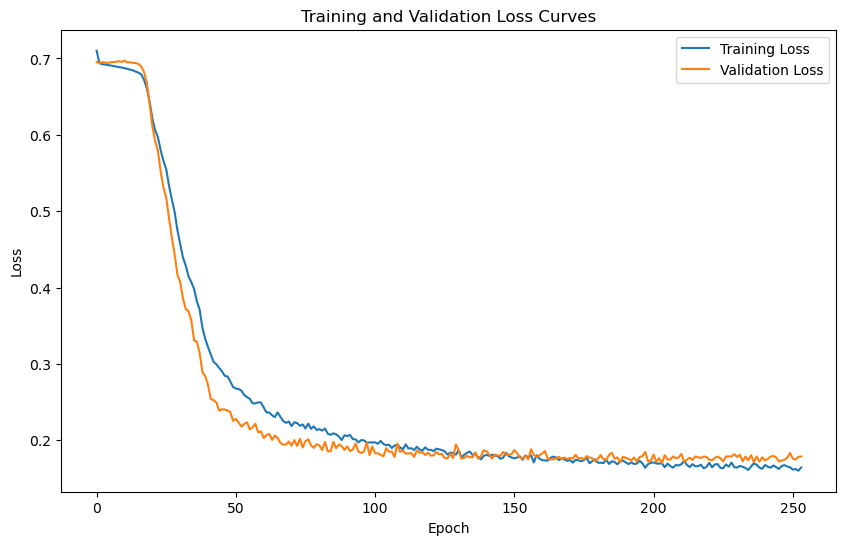

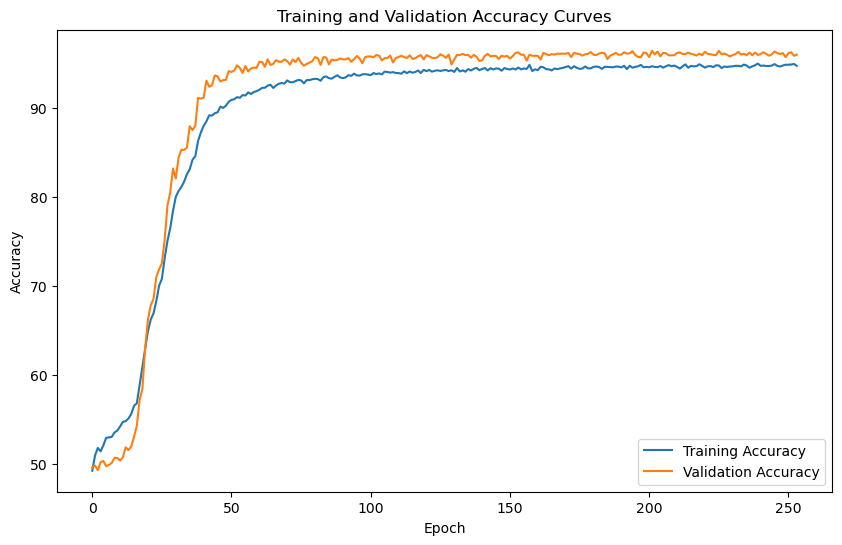


Training took: 946.79 seconds

Test Set Metrics:
Accuracy: 0.9656
Precision: 0.9674
Recall: 0.9642
F1: 0.9658


In [18]:
dimensions = [9, 12, 15, 18]  # List of dimensions

run_all_dims(dimensions, False)